# Porto Seguro’s Safe Driver Prediction

## Simple kernel

### Import libs

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier

from scipy.sparse import csr_matrix

/home/vampire/PycharmProjects/kaggle_club/venv/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Define gini func

In [2]:
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini

### Load files

In [3]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [4]:
df_train.shape, df_test.shape

((595212, 59), (892816, 58))

### View target dist

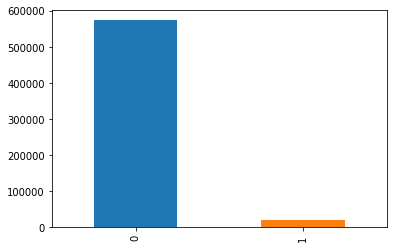

In [5]:
df_train['target'].value_counts().plot(kind='bar')

In [6]:
df_train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


### Drop calculated features

In [7]:
col_to_drop = df_train.columns[df_train.columns.str.startswith('ps_calc_')]
df_train.drop(col_to_drop, axis=1, inplace=True)  
df_test.drop(col_to_drop, axis=1, inplace=True) 

cat_features = [a for a in df_train.columns if a.endswith('cat')]

### Some combinations from other kernels

In [8]:
combs = [
    ('ps_reg_01', 'ps_car_02_cat'),  
    ('ps_reg_01', 'ps_car_04_cat')
]

combs_features = [
#     'ps_car_13_mul_ps_reg_03'
]
for df in [df_train, df_test]:
#     df['ps_car_13_mul_ps_reg_03'] = df['ps_car_13'] * df['ps_reg_03']
    for cmb in combs:
        k = '_plus_'.join(cmb)
        df[k] = df[cmb[0]].astype(str) + '_' + df[cmb[1]].astype(str)
        if k not in combs_features:
            combs_features.append(k)

### OHE

In [9]:
df_train = pd.get_dummies(df_train, columns=cat_features+combs_features)
df_test = pd.get_dummies(df_test, columns=cat_features+combs_features)

In [10]:
df_train.values.shape, df_test.values.shape

((595212, 333), (892816, 332))

### Preparing data for model

In [ ]:
y = df_train['target'].values

df_train.drop(['id', 'target'], inplace=True, axis=1)
df_test.drop(['id'], inplace=True, axis=1)

X = csr_matrix(df_train.values)

X_test = csr_matrix(df_test.values)

scaler = StandardScaler(with_mean=False)
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

### Define model

In [ ]:
model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_valid)[:, 1]

gini = eval_gini(y_valid, y_pred)
print('Gini: ', gini)

### Make submission

In [ ]:
y_test = model.predict_proba(X_test)[:, 1]
sdf = pd.read_csv('data/sample_submission.csv')
sdf['target'] = y_test
sdf.to_csv('submission.csv', index=False)

In [ ]:
!head submission.csv